#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.22260079,  0.90410401,  0.36475311],
       [-0.83371372, -0.01739867,  0.55192275],
       [ 0.50534179, -0.42695811,  0.74989096]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.005782


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000162


In [37]:
C1(dx,dy,dz,Ret)

array([[ 3.44241025e-01, -2.14037113e+00,  2.37616494e+00,
         4.57196019e-02,  9.83700193e-02, -2.70027823e+00,
         3.53415273e-01, -3.07206666e-01,  1.15166867e+00,
        -2.90262451e+00, -3.24840782e+00, -3.98477226e-01,
        -5.55351195e+00, -1.74396414e+00, -4.46778096e-01,
         4.95093603e+00,  6.31740131e-03, -1.91520975e-01,
         8.55150645e-03,  7.83525680e-01,  5.29170180e-02,
         7.30957455e-01, -5.97516233e-02, -6.99163772e-01,
         3.17676655e+00,  2.90365681e-02,  9.77758596e-01,
         2.16354831e+00, -5.17397269e-02,  6.14898941e-01,
         7.33435664e-02,  4.90338071e-01,  5.80051004e-01,
        -3.47282791e-01, -5.63178685e-01, -2.10189565e-01,
        -3.05401220e-01,  2.86311291e+00,  2.96623475e+00,
        -2.65875698e-02, -3.71327013e+00,  5.55715882e-01,
        -6.40669272e-01,  4.09141185e-01, -5.80957170e-02,
        -5.26811327e-02,  2.31111941e-02,  1.64504837e+00,
         8.08109551e-04,  1.32583506e-01],
       [-5.68

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.97561093e+03, -3.26081165e+03, -4.88158388e+03],
       [-1.22836625e+04,  6.75245489e+03, -9.27153145e+03],
       [ 1.36368912e+04, -3.74640217e+03,  3.31349533e+03],
       [ 2.62386347e+02, -1.68450444e+03,  2.76882698e+03],
       [ 5.64548879e+02, -1.35122775e+02,  1.13268386e+04],
       [-1.54969884e+04,  1.24138815e+03, -1.09179786e+04],
       [ 2.02826225e+03, -1.18789833e+02,  2.90836427e+03],
       [-1.76306948e+03, -4.88172153e+03, -6.20508707e+03],
       [ 6.60946560e+03, -2.04585599e+03, -1.02557620e+04],
       [-1.66582606e+04,  2.68339619e+02,  2.40081815e+02],
       [-1.86427227e+04,  1.28506737e+04, -4.11365591e+02],
       [-2.28687432e+03,  1.92614694e+02, -6.91939060e+02],
       [-3.18717936e+04, -1.77259897e+04, -9.42548930e+02],
       [-1.00086694e+04, -1.88849365e+04,  1.02827078e+04],
       [-2.56407466e+03, -7.27315004e+03,  1.15392762e+04],
       [ 2.84135899e+04, -4.91614712e+02, -2.01156572e+03],
       [ 3.62557805e+01, -1.72371270e+04

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000122


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001405


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000029


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 2.45790483e-04, -9.01624294e-02,  1.16253939e-01],
       [ 6.65222716e-01,  4.00668030e-01,  2.77011127e-01],
       [-2.20197504e-01, -1.38961962e-01,  9.28080838e-01],
       [-2.02328753e+00, -6.59252698e-01,  3.60944221e-02],
       [ 3.07060047e+00,  1.57331655e+00, -1.41680419e+00],
       [ 7.63388719e-01, -6.64792613e-01,  2.10473651e+00],
       [-1.84214595e-01,  1.26722501e+00,  6.07644918e-02],
       [-3.28899093e-01, -7.06177616e-01,  4.09778500e-01],
       [-1.16942286e-01,  1.48312361e-01,  2.28389339e-01],
       [ 1.04308876e+00,  4.83725495e-01, -1.58130245e+00],
       [ 1.33779077e+00, -6.99071710e-01,  3.26261349e-01],
       [ 4.34453051e-01,  1.68464358e+00, -4.18347026e-01],
       [ 1.49733456e+00, -1.27001216e-01,  9.95355523e-01],
       [-9.87164296e-02, -1.29311117e+00,  4.81736599e-01],
       [ 1.95185813e-01, -2.41264196e+00,  2.42033024e+00],
       [ 9.53670252e-01, -1.10036122e+00,  3.13567601e-01],
       [ 4.12639518e-01,  3.59738626e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.001096


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001902


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.003418


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 1.65964306, -2.61229239,  1.48740793],
       [-1.10633411, -0.4257594 , -0.93783405],
       [-0.15422515, -0.0963588 , -0.53205668],
       [ 2.07196144, -1.69654066, -0.54904719],
       [ 1.57041699,  0.35851295, -0.12902758],
       [-1.46223593, -0.6965017 , -0.02520677],
       [ 0.53609906,  0.57000316, -1.08289511],
       [ 1.07348249, -0.03122322,  0.48468761],
       [ 0.05680779, -1.04714732, -0.05292134],
       [-1.50576438,  0.6675775 ,  0.03984156],
       [ 0.68008146, -0.05068095,  0.27125698],
       [ 0.16502314,  0.36443878,  0.07632319],
       [-0.51735029, -0.06345327, -0.02292295],
       [-0.47348907, -0.28119021, -0.70304979],
       [-1.14333635,  0.43207387,  0.19528206],
       [-0.53890223,  0.53629769, -0.00929645],
       [-0.56171403,  0.48230929, -0.35778336],
       [-0.82482736,  0.67047712,  0.55380935],
       [ 0.55894029, -0.21013199,  0.33339926],
       [-0.47511757, -0.46473056, -0.12886677],
       [-1.35597776, -0.15093201,  0.224

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.85339325e-03, -1.09224131e-03,  9.59792209e-03,
         6.22493204e-03, -2.68340900e-02,  2.48957367e-02,
        -1.07941257e-02,  1.00086686e-02,  7.28554019e-04,
        -1.85634870e-02,  9.19328043e-03, -1.88426403e-02,
         1.00964629e-02,  1.59092090e-02,  4.33790899e-02,
         1.26703804e-02, -8.09343806e-03, -1.00741157e-02,
         1.61971875e-02, -2.79996282e-02, -1.28961857e-03,
        -7.34278499e-03,  4.21575285e-03, -2.57149282e-02,
        -2.80518882e-02,  1.12859191e-02,  3.95455718e-03,
         2.55489395e-03, -1.22306021e-02,  9.29940200e-04,
         3.97322276e-03,  1.50869689e-03, -3.34656000e-02,
        -7.23836308e-03, -1.28389919e-02, -1.19367074e-03,
        -2.42670371e-02,  3.13650343e-03,  9.30919621e-03,
        -1.56513542e-02, -1.16642529e-02,  9.66761542e-03,
         2.72576329e-03,  2.35679771e-03, -2.03891514e-02,
         1.49551899e-04,  2.24955422e-02,  6.22978671e-03,
        -1.18873387e-02, -2.48370646e-02],
       [-1.16

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001244


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 1.79371686e-07,  1.13430463e-06,  5.20013245e-07,
        -3.44163025e-06, -4.92362679e-06, -1.17792952e-06,
         1.30302080e-06,  3.09631358e-08, -1.04347224e-07,
         1.39742575e-06,  2.94811218e-07, -1.84288072e-06,
         1.75851764e-07, -2.15810530e-07,  3.36296849e-07,
         2.28820084e-06, -7.32745302e-07, -1.77810279e-06,
         2.02173857e-06, -3.71152679e-06, -3.37273539e-07,
         2.91915818e-06, -1.78451035e-06,  1.92154333e-06,
        -2.13716962e-06, -3.09538893e-06,  3.48731445e-06,
        -3.27928538e-07, -6.76507419e-07,  6.25145075e-07,
         8.35590136e-07,  2.32135779e-06, -2.12930121e-06,
        -8.27201177e-07,  3.74522892e-07, -8.34837214e-08,
         3.03757554e-07,  1.60793110e-06,  6.33216206e-07,
        -2.24727701e-06, -1.32529772e-06,  1.11996662e-06,
         9.37271100e-08, -2.33403648e-07,  8.61665962e-07,
         2.63108758e-07, -4.86917372e-06, -2.85088393e-06,
        -1.03107823e-06, -2.01904976e-06],
       [-6.81

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.97561093e+03,  1.22836625e+04, -1.36368912e+04,
        -2.62386347e+02, -5.64548879e+02,  1.54969884e+04,
        -2.02826225e+03,  1.76306948e+03, -6.60946560e+03,
         1.66582606e+04,  1.86427227e+04,  2.28687432e+03,
         3.18717936e+04,  1.00086694e+04,  2.56407466e+03,
        -2.84135899e+04, -3.62557805e+01,  1.09914538e+03,
        -4.90773858e+01, -4.49668047e+03, -3.03692562e+02,
        -4.19498964e+03,  3.42916594e+02,  4.01252462e+03,
        -1.82315710e+04, -1.66641850e+02, -5.61138976e+03,
        -1.24166772e+04,  2.96936048e+02, -3.52892589e+03,
        -4.20921217e+02, -2.81406683e+03, -3.32893240e+03,
         1.99306772e+03,  3.23210159e+03,  1.20628504e+03,
         1.75270796e+03, -1.64315022e+04, -1.70233219e+04,
         1.52586965e+02,  2.13105833e+04, -3.18927231e+03,
         3.67682269e+03, -2.34807514e+03,  3.33413292e+02,
         3.02338809e+02, -1.32635928e+02, -9.44098845e+03,
        -4.63776814e+00, -7.60901242e+02],
       [ 3.26

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.003585


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-1.39974836e+01,  1.19805446e+05,  2.15843470e+04],
       [-2.79349239e+02,  2.81918283e+06,  2.52630280e+03],
       [-4.42103396e+02,  8.97549843e+05,  3.56832109e+06],
       [-1.56454726e+02,  1.55244758e+06,  2.79043372e+04],
       [ 8.41220556e-03, -9.00715562e+02,  8.15785141e+02],
       [ 4.66502689e+00, -3.42008090e+04, -1.29213217e+04],
       [ 2.00394636e+01, -1.03745349e+04, -1.92053987e+05],
       [-1.70445897e+01, -6.52985077e+04,  2.37478085e+05],
       [-2.86448893e+02,  2.16449813e+06,  7.28961492e+05],
       [ 2.67981149e+00, -2.69055966e+04, -1.63210013e+02],
       [ 1.65400509e+02,  4.50877841e+05, -2.12169729e+06],
       [ 4.33018023e+02, -3.14030446e+06, -1.23367675e+06],
       [-3.01433697e+01,  4.84902485e+05, -1.80433197e+05],
       [-4.79084334e+02,  2.26310654e+06,  2.57625889e+06],
       [ 9.57464415e+01, -6.75736247e+05, -2.91414129e+05],
       [-1.19899135e+01, -2.32808646e+06,  2.44932079e+06],
       [-1.30764445e+02, -2.23283970e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 5.94497792e+08,  2.21728999e+06, -1.19216923e+07],
       [-1.10301221e+07,  2.51538298e+05, -2.81919375e+08],
       [-6.32081345e+08,  3.56769533e+08, -8.98175572e+07],
       [ 2.17336099e+07,  2.79258535e+06, -1.55242607e+08],
       [-8.21129521e+08,  2.86677901e+02,  8.78383928e+03],
       [-6.10898437e+07, -1.29818006e+06,  3.41403331e+06],
       [-5.32128920e+08, -1.92580794e+07,  9.84775392e+05],
       [-6.29736118e+08,  2.36854646e+07,  6.46751004e+06],
       [-1.23960358e+08,  7.28838771e+07, -2.16462084e+08],
       [-4.82699216e+08, -6.41082317e+04,  2.64277485e+06],
       [-7.58596360e+08, -2.12244830e+08, -4.51628813e+07],
       [-7.94550272e+08, -1.23446335e+08,  3.13951789e+08],
       [-9.93678158e+08, -1.81416939e+07, -4.85886177e+07],
       [-3.58826715e+08,  2.57590365e+08, -2.26346176e+08],
       [-7.02839359e+08, -2.92109940e+07,  6.75040472e+07],
       [-5.33690757e+08,  2.44879243e+08,  2.32755813e+08],
       [-3.89685193e+08,  3.55348676e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.002661


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002373


In [82]:
d_me_

array([[ 4.02743230e-03,  6.54603575e+02, -6.95319936e+02],
       [ 5.50821536e-02, -5.07631846e+02, -4.87559205e+01],
       [ 2.50040134e-02, -2.35609205e+02, -1.69574038e+01],
       [ 1.67870817e-02, -9.91225555e+01, -7.04474677e+01],
       [ 1.58995149e-07,  8.68043699e+02, -8.68089294e+02],
       [ 5.56882469e-03,  9.59330861e+01, -1.52191543e+02],
       [-5.14069589e-03,  6.48037279e+02, -5.96141275e+02],
       [ 4.02283323e-03,  6.40211393e+02, -6.80880567e+02],
       [-7.28058607e-02, -2.46766718e+00,  7.37917670e+02],
       [ 1.60768653e-04,  6.04963861e+02, -6.06618525e+02],
       [ 1.23928765e-02,  1.83956995e+02, -3.09153210e+02],
       [-1.16399460e-02,  9.40174468e+00,  1.08178929e+02],
       [-3.57960640e-04,  2.42055229e+02, -2.38451549e+02],
       [ 4.14978111e-02, -3.12885428e+02, -1.06289697e+02],
       [ 3.56970070e-03,  6.12040037e+02, -6.48130456e+02],
       [-2.18528122e-02,  1.54818813e+02,  6.59199671e+01],
       [ 4.41065537e-04, -7.75787860e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.97561093e+03,  1.22836625e+04, -1.36368912e+04,
        -2.62386347e+02, -5.64548879e+02,  1.54969884e+04,
        -2.02826225e+03,  1.76306948e+03, -6.60946560e+03,
         1.66582606e+04,  1.86427227e+04,  2.28687432e+03,
         3.18717936e+04,  1.00086694e+04,  2.56407466e+03,
        -2.84135899e+04, -3.62557805e+01,  1.09914538e+03,
        -4.90773858e+01, -4.49668047e+03, -3.03692562e+02,
        -4.19498964e+03,  3.42916594e+02,  4.01252462e+03,
        -1.82315710e+04, -1.66641850e+02, -5.61138976e+03,
        -1.24166772e+04,  2.96936048e+02, -3.52892589e+03,
        -4.20921217e+02, -2.81406683e+03, -3.32893240e+03,
         1.99306772e+03,  3.23210159e+03,  1.20628504e+03,
         1.75270796e+03, -1.64315022e+04, -1.70233219e+04,
         1.52586965e+02,  2.13105833e+04, -3.18927231e+03,
         3.67682269e+03, -2.34807514e+03,  3.33413292e+02,
         3.02338809e+02, -1.32635928e+02, -9.44098845e+03,
        -4.63776814e+00, -7.60901242e+02],
       [ 3.26

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

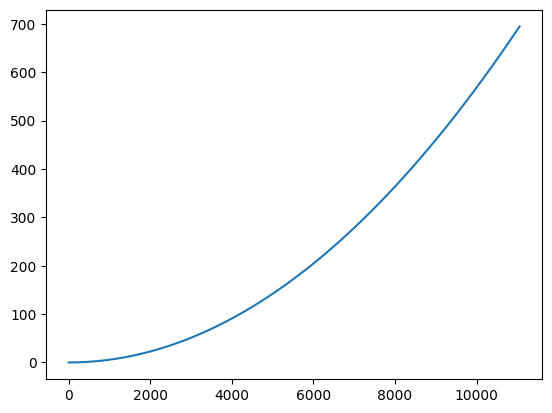

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_24802/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

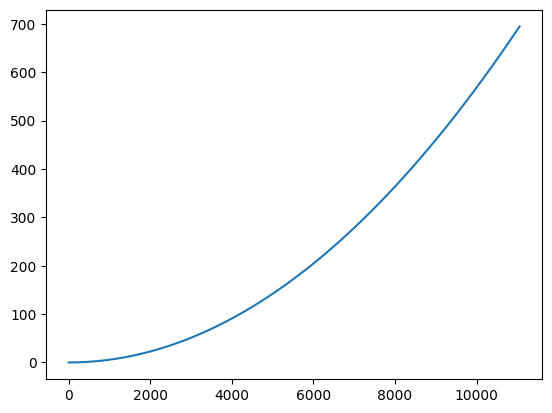

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, 
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        global_force=[-10,0,20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0])

In [113]:
d

array([-7.05147750e-06, -6.65367100e-08,  1.41769582e-05,  1.44778793e-06,
        1.74858422e-06,  1.13605431e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [114]:
f

array([-1.00000000e+01, -8.37864663e-16,  2.00000000e+01,  3.94129174e-15,
        1.01675929e-15, -7.91033905e-16,  9.87206850e+00, -3.05675021e-02,
       -1.07838097e-01, -2.02690310e-03, -1.73997236e-01,  2.99464928e-02,
        9.02939690e-02, -3.92960434e-02, -1.98477415e+01,  3.86750341e-02,
        1.23200864e-01, -1.59047604e-03,  3.76375299e-02,  6.98635455e-02,
       -4.44204429e-02, -9.64417725e-02, -1.83601343e-03, -8.72036301e-02])

In [115]:
def PipeForce(X,Y,Z,vessel_force, coef=1, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    global_force=np.zeros(len(X)*6) 
    global_force[-6:]=np.multiply(coef,np.array(vessel_force))

    d,f=FEA_u(coord,elcon,bc_node,bc_val,global_force,E,G,A,Iy,Iz,J)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[67067.8422171882,
                 8866784.826883841, 
                 136429924.3688211, 
                 760945444.8381816, 
                 -5770549859.826721, 
                 374662591.12388337],1e-10)

In [117]:
fors

array([[-6.84410122e-06, -8.86777229e-04, -1.36430674e-02],
       [ 8.54015525e-10,  2.02240737e-08,  9.34551991e-09],
       [ 2.36286724e-09, -6.67786337e-09,  7.04319802e-09],
       [ 3.12411430e-09,  2.56297377e-08, -3.48443052e-09],
       [ 4.30736691e-09,  2.32831887e-09, -1.21783614e-08],
       [ 5.52972779e-09, -6.91948721e-09,  9.43964551e-09],
       [ 4.59840521e-09, -1.25380959e-08,  3.18259481e-08],
       [ 5.29689714e-09,  4.37427054e-08,  8.70204531e-09],
       [ 3.60887498e-09, -3.58642893e-09,  9.26775101e-10],
       [ 4.65661287e-10, -8.08735479e-09,  2.36614142e-08],
       [-4.42378223e-09, -1.87963991e-08,  1.41153578e-08],
       [-4.07453626e-09,  4.20153638e-09,  2.13804014e-08],
       [-8.84756446e-09, -3.92375910e-10,  6.90488378e-09],
       [-7.91624188e-09, -3.89059096e-09, -3.68163455e-09],
       [-9.31322575e-09, -3.62950203e-09,  2.91038305e-10],
       [-1.23400241e-08, -3.17361945e-09, -2.03435775e-08],
       [-1.55996531e-08,  1.03237170e-08

### Vessle Simulation

In [118]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [119]:
vehicle=semisub('DPcontrol',1,3,40.0,0,0) 

In [120]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [121]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

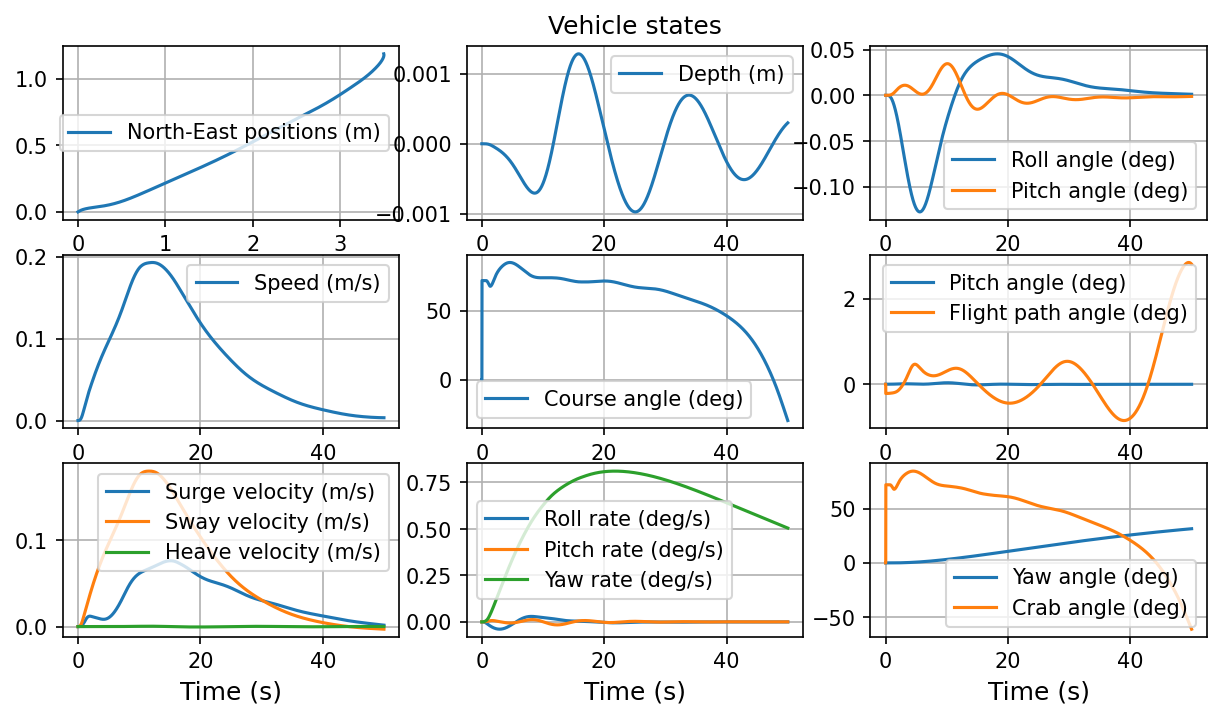

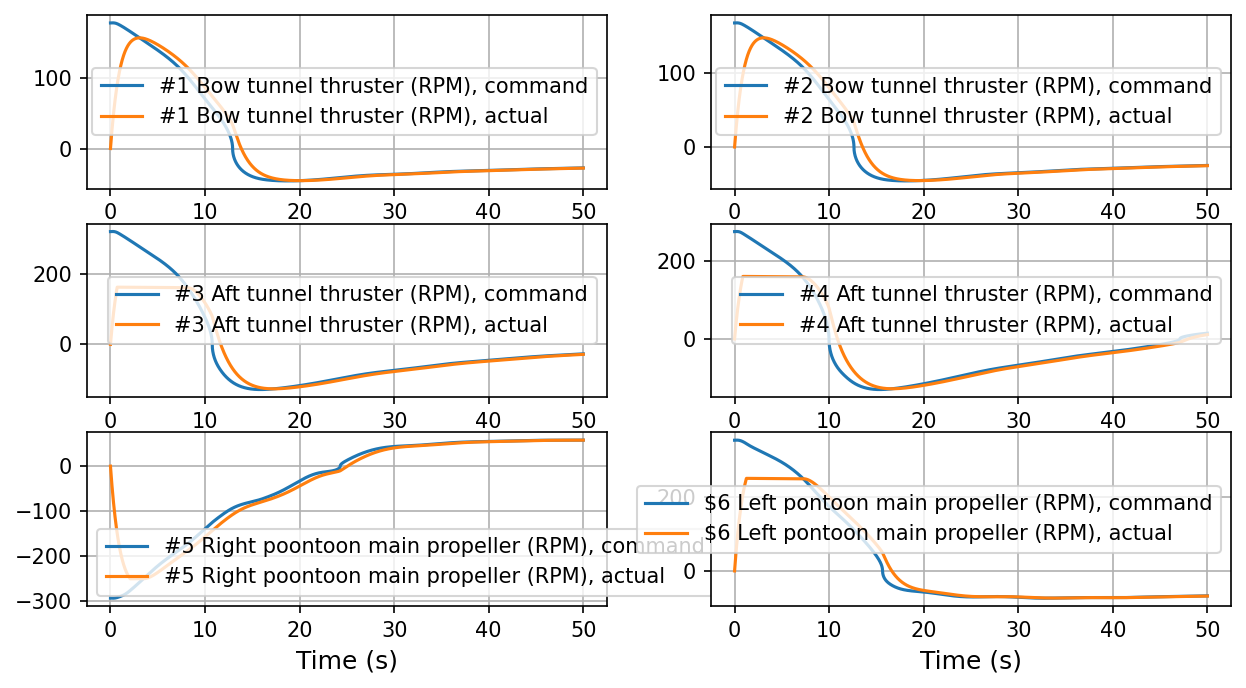

In [122]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [123]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

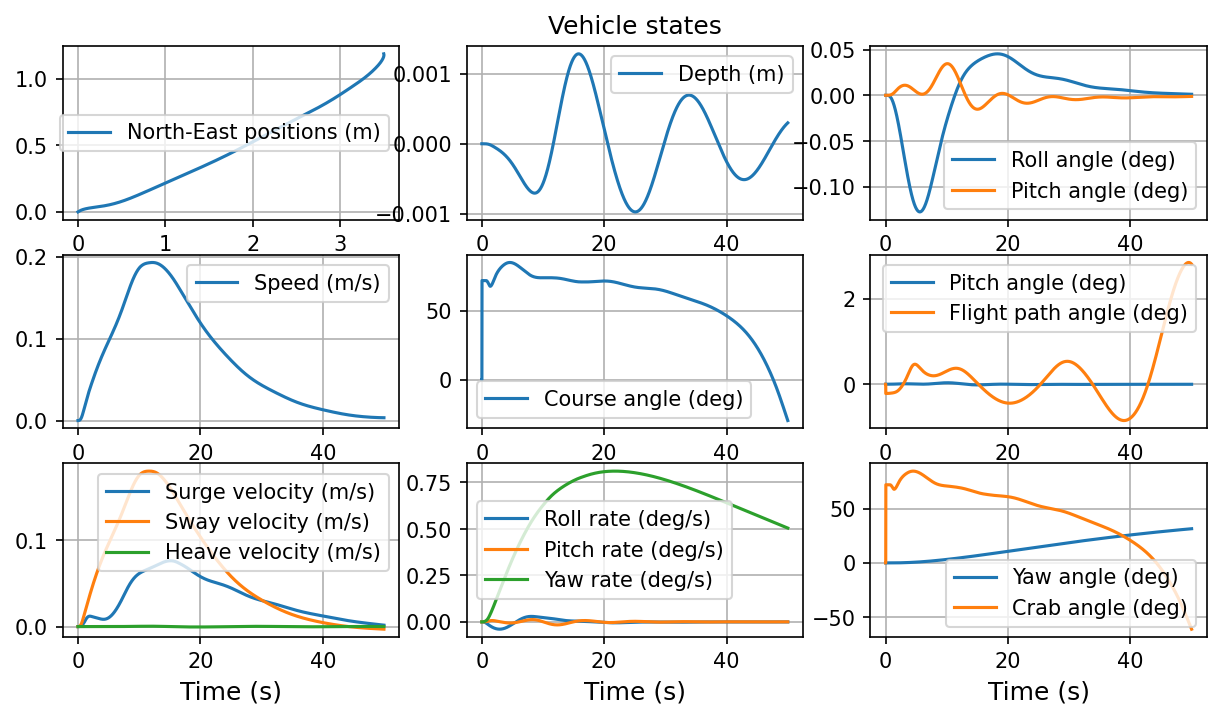

In [124]:
plotVehicleStates(simTime, simData, 3)

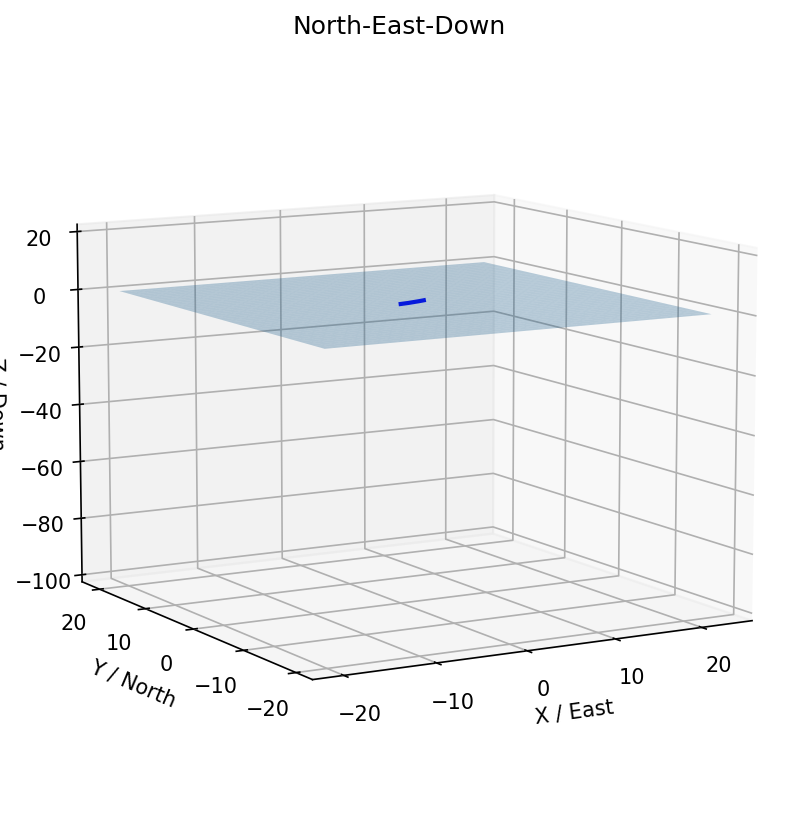

In [125]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [126]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

-7.422234410814355e-05

In [131]:
ssa(simData[:, 4][int(idx)])

1.745752439541448e-05

In [132]:
ssa(simData[:, 5][int(idx)])

8.669735546362745e-05

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t=0

In [136]:
def grayscott1d(t, Q, force_schedule, T): 
#     print(t,T.my_t,t-T.my_t)
    print(t)
    if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
        return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
    print(n_[2])

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    
    
    fors, mom, angle = PipeForce(x,y,z,n_,force_schedule)
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()


    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 50)
T_ = MyTime()
force_schedule=np.array([-91.27851669645848,
                         -9.257472683368384,
                         -0.4899332658161373,
                         -22.899651335497204,
                         41.18016717115302,
                         -72.90194510596348])*1e-12

In [163]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,  
             tspan, 
             q0,
#              t_eval=[i+1 for i in range(tspan[-1])],
             rtol=1e-2,
             args=(force_schedule, T_,))
print(datetime.now() - startTime1)

0.0
138564169.45197234
0.0017715894388909633
138570211.11873275
0.026877918318498596
138416436.43207824
0.04031687747774789
138367401.20215878
0.10751167327399438
137963150.60738617
0.11945741474888263
137907104.31826085
0.13438959159249297
137850205.25648993
0.13438959159249297
137856246.5007985
0.2960530253758801
136673864.65707576
0.3768847422675736
136073190.35605645
0.7810433267260414
132775300.78873378
0.8528937417408801
132164108.9567587
0.9427067605094285
131362618.39477308
0.9427067605094285
131368653.0253014
1.2613895279533496
128415659.09438567
1.42073091167531
126927140.61528297
2.2174378302851125
119394648.56187549
2.3590746158157443
118071527.26448049
2.5361205977290338
116364789.9086003
2.5361205977290338
116370787.45603201
2.928093837303532
112662207.17752707
3.1240804570907805
110866594.59472378
4.1040135560270254
101802217.48631239
4.278223884726803
100194578.53972882
4.495986795601524
98252938.15552652
4.495986795601524
98258846.81177863
5.028066522177957
93685224.18

In [164]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [165]:
fin=us

In [166]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.344e-01 ...  4.994e+01  5.000e+01]
        y: [[ 0.000e+00 -2.917e-13 ... -8.712e-09 -8.720e-09]
            [ 2.256e+02  2.256e+02 ...  2.256e+02  2.256e+02]
            ...
            [ 0.000e+00 -6.448e-05 ... -1.259e-06 -1.259e-06]
            [ 0.000e+00 -6.592e-05 ... -1.292e-06 -1.291e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 116
     njev: 0
      nlu: 0

In [167]:
t=fin.t

In [168]:
fin=fin.y.T

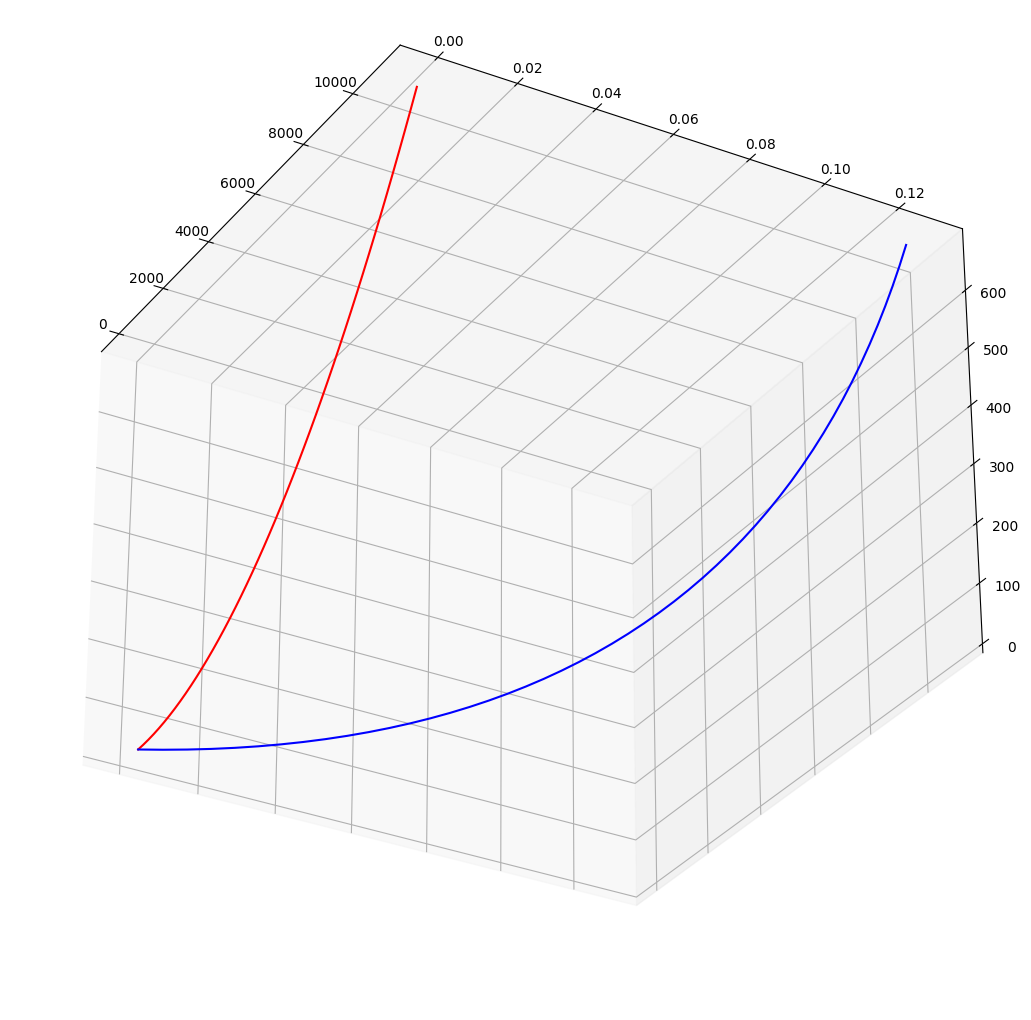

In [169]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [170]:
X,Y,Z

(array([-8.71972660e-09,  2.25564997e+02,  4.51129991e+02,  6.76694983e+02,
         9.02259970e+02,  1.12782495e+03,  1.35338993e+03,  1.57895489e+03,
         1.80451985e+03,  2.03008480e+03,  2.25564974e+03,  2.48121467e+03,
         2.70677959e+03,  2.93234450e+03,  3.15790940e+03,  3.38347430e+03,
         3.60903918e+03,  3.83460405e+03,  4.06016891e+03,  4.28573377e+03,
         4.51129862e+03,  4.73686346e+03,  4.96242829e+03,  5.18799312e+03,
         5.41355794e+03,  5.63912276e+03,  5.86468758e+03,  6.09025239e+03,
         6.31581720e+03,  6.54138201e+03,  6.76694682e+03,  6.99251163e+03,
         7.21807645e+03,  7.44364126e+03,  7.66920608e+03,  7.89477091e+03,
         8.12033573e+03,  8.34590057e+03,  8.57146541e+03,  8.79703026e+03,
         9.02259511e+03,  9.24815997e+03,  9.47372485e+03,  9.69928973e+03,
         9.92485462e+03,  1.01504195e+04,  1.03759844e+04,  1.06015494e+04,
         1.08271143e+04,  1.10526792e+04]),
 array([-2.05608830e-09,  4.94765506e-03,  9

In [171]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [172]:
us=fin.T

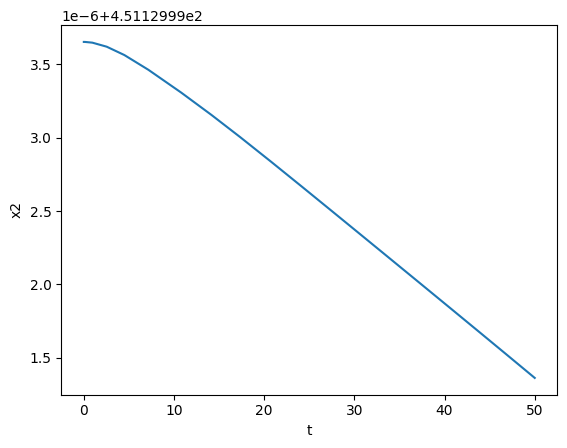

In [173]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

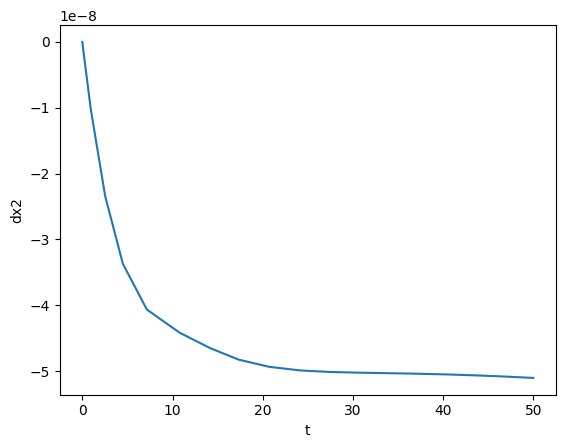

In [174]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

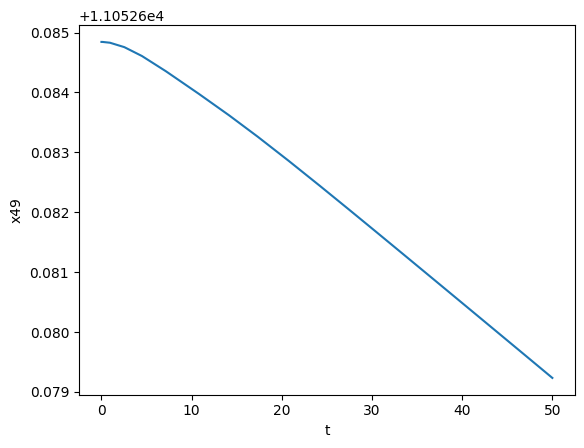

In [175]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

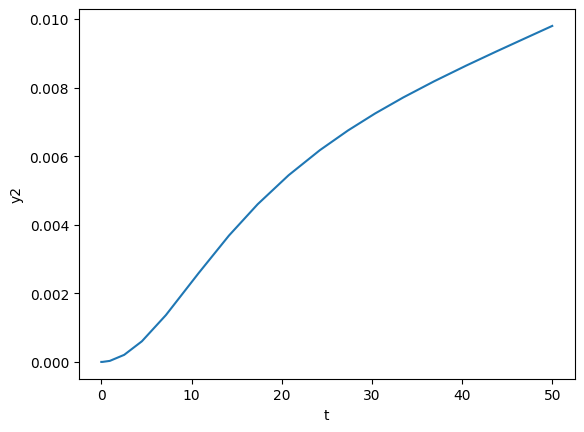

In [176]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

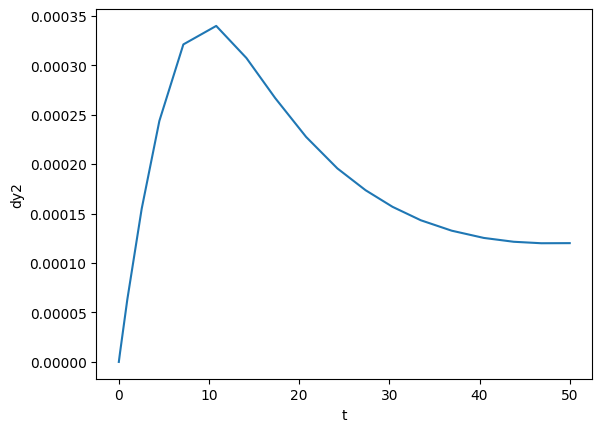

In [177]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

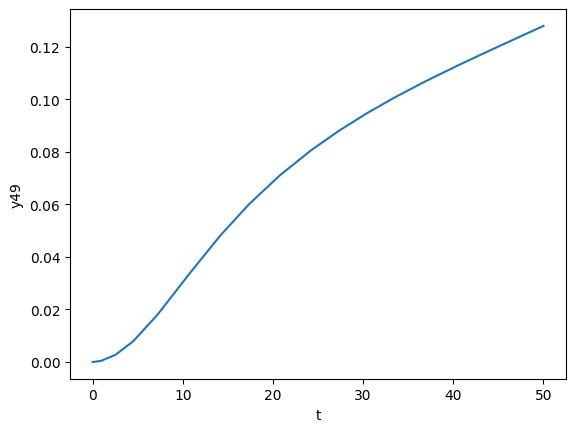

In [178]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

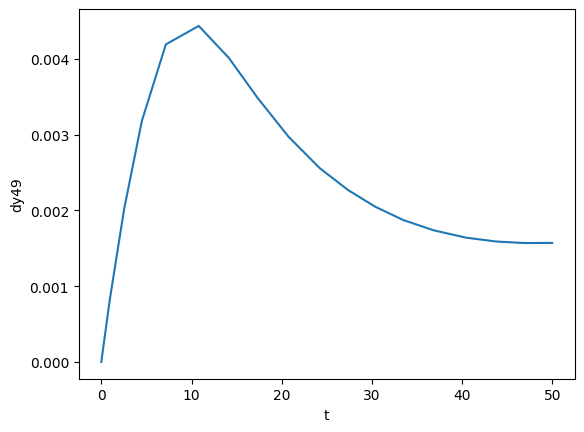

In [179]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

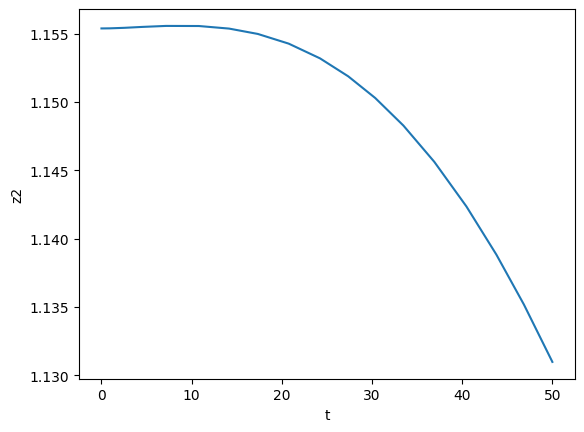

In [180]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

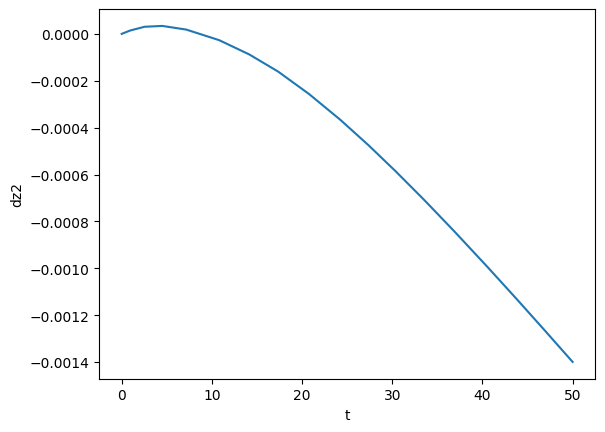

In [181]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

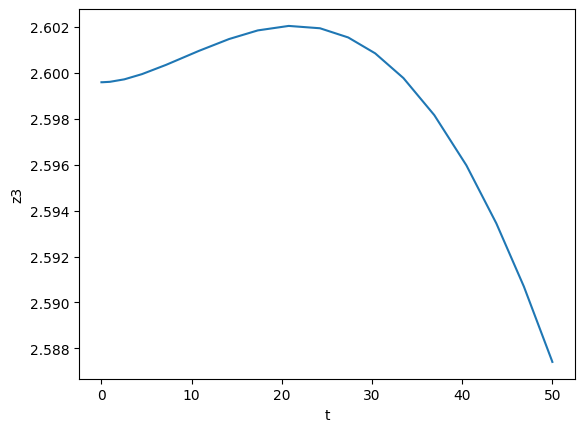

In [182]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

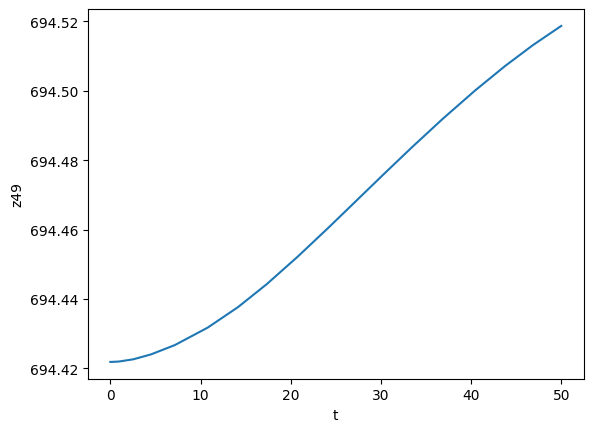

In [183]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

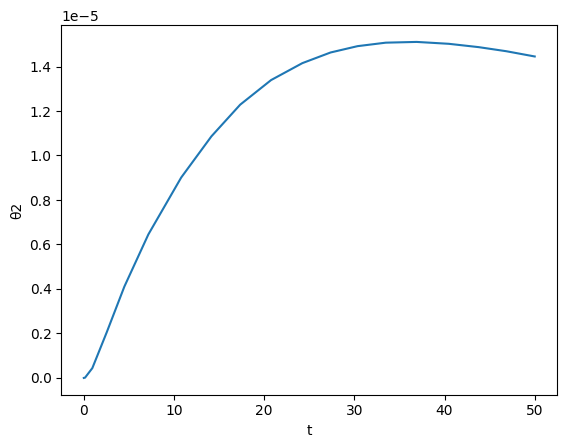

In [184]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

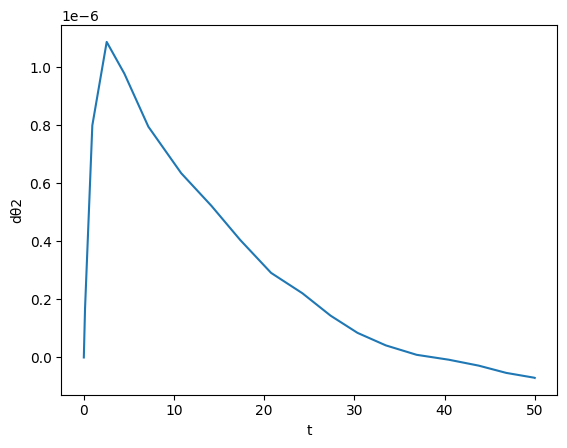

In [185]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

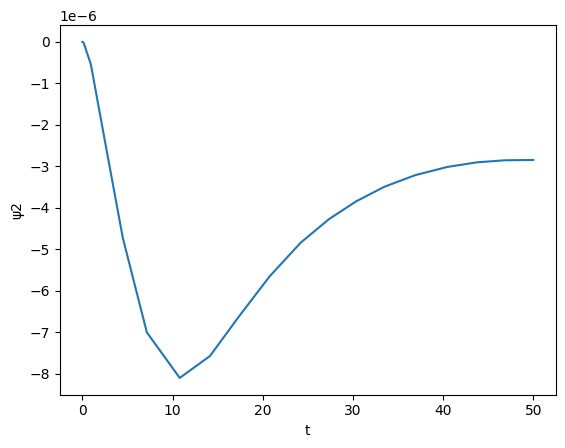

In [186]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

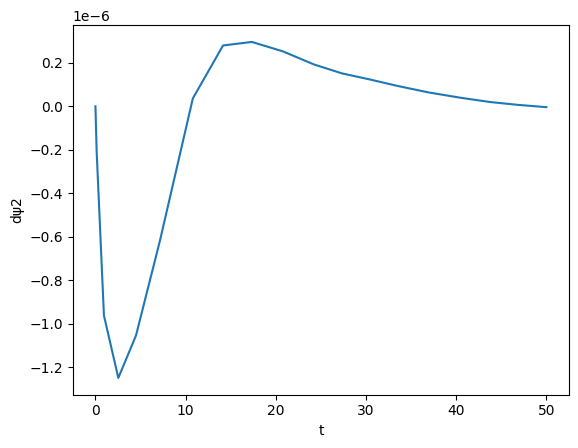

In [187]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()